## Purpose

The goal of this tutorial is to learn how to asses whether 2 successively exported IFC building models are different by testing whether entity instances of the latest are present in the original one or entity instances of the original one are present in the latest version. 

The data is stored using the Industry Foundation Class (IFC) format, which is the standard format to digitally represent anything related to the construction industry. This format stands as an open-standard, and enables to share building models in form of IFC files between the different actors of a construction project. We can think of IFC as the PDF for the construction industry.

For example, how could you find the difference between those 2 files?<!-- TEASER_END -->

![find_diff.png](../images/find_diff.png)

Or even those ones, which are simpler.

![min_diff.jpg](../images/min_diff.jpg)

#### But first, why would we want to compare two IFC files?

IFC files allow actors involved in a construction project to store an engineering model of the elements that form the building or the infrastructure modeled. In order to rely on this model, the data should be accurate or at least verifiable. Indeed, the models are not carved in stone and will know many changes throughout the building lifecycle, from the pre-design phase to the renovation or demolition phases.

It is therefore essential to provide software programs that let the users know whether they are receiving a newer version from their local copy, to be able to assess quantitatively and qualitatively the differences that have been introduced.

Given the complexity of a construction project in terms of the diversity of domains, the resulting number of actors, and some additional stakeholders, storing satisfying data for all in discipline related files is the daunting task IFC is trying to achieve.

Indeed, IFC files can become rather large and it is advised to use clever ways to process its data. The processing in question in this tutorial is to spot the differences among entity instances between two IFC files.

Before diving in, let's review quickly some of the intricacies of the IFC format. 

### Background on the IFC format and comparison strategy

The IFC format defines a data schema divided into resources block. For each block, IFC entity types enable to model different elements. Those elements get an "Ifc" prefix and can be for example IfcWall, IfcSlab, IfcPropertySet, IfcRelDefinesByProperty, IfcRepresentation...

Whithin the data schema, which is object-oriented, there is a hierarchy between entity types, involving abstract entity types. For example, the IfcBuildingElement is an abstract entity type.

For example the defiinition of the IfcBuildingElement entity type is given below (source: http://standards.buildingsmart.org/MVD/RELEASE/IFC4/ADD2_TC1/RV1_2/HTML/schema/ifcproductextension/lexical/ifcbuildingelement.htm)


The building element comprises all elements that are primarily part of the construction of a building, i.e., its structural and space separating system. Building elements are all physically existent and tangible things

    NOTE  Definition from ISO 6707-1:
    Major functional part of a building, examples are foundation, floor, roof, wall.

![ifc_schema.png](../images/ifc_schema.png)

The above diagram is an example of the inheritance links existing in the IFC data schema.

Moreover, an IFC file uses the entity types of the IFC schema with it own hierarchy.
It means the IFC instances implemented, like the 4 IfcWall instances of a very simple house, have relationships with other IFC instances. For example, the IfcWall instances are contained in an IfcBuildingStorey instance, itself contained in a IfcBuilding instance, itself contained in a Ifcsite instance, and itself eventually contained in an IfcProject instance. In addition, for example, the attributes of an IfcWall are often grouped in IfcPropertySet instances, which are for example related by an IfcRelDefinesByProperty instance. Relationships betweem instances are also objectified: they are also represented by IFC instances. 

## Download resources from the web

Let's import the ifcopenshell python package and the IFC Duplex file.  

### Download ifcopenshell-python

In [5]:
import urllib.request
url = 'https://s3.amazonaws.com/ifcopenshell-builds/ifcopenshell-python-36-v0.6.0-0d93633-linux64.zip'
filename = 'ifcopenshell.zip'
urllib.request.urlretrieve(url, filename)

KeyboardInterrupt: 

In [ ]:
import zipfile
with zipfile.ZipFile('ifcopenshell.zip', 'r') as zip_ref:
    zip_ref.extractall('ifcopenshell')

### Download an IFC file

In [ ]:
import urllib.request
url = 'http://openifcmodel.cs.auckland.ac.nz/_models/030811DuplexModel-IFC-2011-05-05.zip'
filename = 'Duplex_files.zip'
urllib.request.urlretrieve(url, filename)

('Duplex_files.zip', <http.client.HTTPMessage at 0x104dea6a0>)

In [ ]:
import zipfile
with zipfile.ZipFile('Duplex_files.zip', 'r') as zip_ref:
    zip_ref.extractall('Duplex')

BadZipFile: File is not a zip file

## Getting started

Once we've downloaded the resources, we can get started and import the main libraries we'll be using.

In [ ]:
import json
import math
import sys
import random

In [ ]:
import ifcopenshell
import ifcopenshell.geom 

import OCC 
import OCC.BRepTools

We can open the IFC file we've dowloaded. 

In [ ]:
file = ifcopenshell.open('Duplex/Duplex_A_20110505.ifc')

And get the IfcBuildingElement entitity instances in a `building_elements` variable.

In [ ]:
building_elements = file.by_type("IfcBuildingElement")

 Let's take 2 random entity instances to compare them.

In [ ]:
random_entity1 = building_elements[4]
random_entity2 = building_elements[5]

Get the information of the instances. Generally speaking, this information as it is returned gives describes an instance, regarding to its physical placement, its geometry representation, and any other attached piece of information.

In [ ]:
info1 = random_entity1.get_info(recursive=True, include_identifier=False, ignore={"GlobalId", "OwnerHistory"})
info2 = random_entity2.get_info(recursive=True, include_identifier=False, ignore={"GlobalId", "OwnerHistory"})

info3 = info1

Let's pretty print the information of and an entity instance.

In [ ]:
from IPython.core.display import HTML
import pprint
HTML("<pre style='white-space:pre;font-size:10px;line-height:14px'>{}</pre>".format(
    pprint.pformat(info1))
)

Intuitively, we can compare 2 entities using those info variables.

In [ ]:
print(info1 == info2)
print(info1 == info3)

False
True


But what if we wanted to check whether an entity belongs to a set of entities. In other words, how do we test whether an entity of a new file we've received has been added or remained the same? 

For this, we need to store the entities - still in the form of their information - to a set.

The cell below produces an error since a set must be made of immutable/hashable elements.

In [ ]:
a_set1 = {info1, info2, info3}
a_set2 = {info1, info2}
print(a_set1 == a_set2)

TypeError: unhashable type: 'dict'

In order to reach our goal, which is to create a set of the information of entity instances, we will have to transform the data in which the information of an entity is stored, and which is mutable for now (a dictionary), into an immutable one (a tuple for example). For this, we will use a newly created class that instantiates and immutable data container, and for which we can tailor the tolerance for squashing floating values into a hash number.

### Frozensets

Alternatively, we could also store the information on an entity as embedded frozenset, which is the immutable version of the python set. 

In [ ]:
info1 = random_entity1.get_info(include_identifier=False, recursive=True, return_type=frozenset)
info2 = random_entity2.get_info(include_identifier=False, recursive=True, return_type=frozenset)

We could create a mini set of those embedded frozensets to test membership of the entities.

In [ ]:
new_set = {info1, info2}
print(info2 in new_set)

True


Let's see some definitions about the mutable and hashable notions. 

### Definitions

#### Mutable

A data structure is mutable if it can be modified after its intitialization, such as a list, a set, a dictionary.
Conversely, a tuple, an integer, a string, or a frozenset cannot be modified after initialization, so they are immutable data types.

#### Hashable

A hashing function maps an immutable variable to an integer. This integer has to be unique and represents the input value in a more simpler form.
We say that a variable is hashable if it can be hashed with the hash method of its underliying data type. For this, the object must be immutable.
The input of the hashing function is unbounded and can be of any type as long as it is immutable. However, the output of the function is bounded (there is a finite number of hashes), which can lead to Hashing collision, happening when two different outputs share the same hash value. Consequently, the more the the input data, the more frequent an output hash risks to be and thus the higher the risk of Hashing collision. 
In the example (https://en.wikipedia.org/wiki/Hash_table#/media/File:Hash_table_3_1_1_0_1_0_0_SP.svg) below, Hash collision happens for the hash value `02`, which is produced by both `John Smith` and `Sandra Dee`.

![hash_table.png](../images/hash_table.png)

### Comparing 2 IFC files

In the context of comparing 2 files, if we look at the big picture we would say that we have to assess, for each entity  instance of the new file, whether it belongs to the old file or not. To do so, the entities of the old file have to be stored in a container, such as a set.
Thus, the key operation of this tutorial is **membership testing**.

As said earlier, the information variable of each entity instance of the original file have to be stored in a set. But each of this informaton variable comes in the form of a dictionary. However, a set, as the keys of a dictionary, needs its elements to be immutable so that they can be hashable.

To do so, we create a new data container - a fuzzy dictionary - which will have, unlike the python dictionary, a hash method. To create this immutable/hashable data structure, we transform the input values coming in the form of a dictionary to a tuple, which is an immutable data structure which allows hashing.

### Methods to create an immutable data structure

The first method enables to get the information of an IFC file. The second one transforms this information into an immutable data structure.

In [ ]:
def info_as_dictionary(e):
    return e.get_info(recursive=True, include_identifier=False, ignore={"GlobalId", "OwnerHistory"})
    
def to_fuzzy(e):
    return fuzzy_dict(info_as_dictionary(e), guid=e.GlobalId)

### Make the dictionaries immutable

Let's create the `fuzzy_dict` data container. 

In [ ]:
class fuzzy_dict(object):
    def __init__(self, d, eps=1e-5, guid=None):
        self.d = d
        self.eps = eps
        self.guid = guid
        
        mod = - int(round(math.log10(eps * 100)))
        def c(v):
            if isinstance(v, float):
                # print "round(%r, %r) = %r" % (v, mod, round(v, mod))
                return round(v, mod)
            elif isinstance(v, dict):
                return tuple(sorted((k,c(v)) for k, v in v.items()))
            elif isinstance(v, (tuple, list)):
                return type(v)(map(c, v))
            else:
                return v
                
        self.h = hash(c(self.d))
        
    def __hash__(self):
        return self.h
         
    def __eq__(self, other):
    
        def eq(v1, v2):
            if type(v1) != type(v2):
                return False
            if isinstance(v1, float):
                if abs(v1 - v2) > self.eps: return False
            elif isinstance(v1, dict):
                if not (fuzzy_dict(v1, eps=self.eps) == fuzzy_dict(v2, eps=self.eps)): return False
            elif isinstance(v1, (tuple, list)):
                if len(v1) != len(v2): return False
                for a, b in zip(v1, v2):
                    if not eq(a, b): return False
            else:
                if v1 != v2: return False
            return True
        
        if set(self.d.keys()) != set(other.d.keys()): return
        
        for v1, v2 in ((self.d[k], other.d[k]) for k in self.d):
            if not eq(v1, v2): return False
            
        return True



### Rounding the float values

As it can be seen, the `eq` method uses a `mod` variable to define tolerance in the comparison. This `mod` is calculated on the basis of an epsilon value. 

Let
* $int$ be a floor or ceiling function
* $round$ be another floor or ceiling function
* $log_{100}$ be the logarithm base 10
* ${\epsilon}$ be the tolerance to compare two floating point numbers

The mod function can thus be expressed as

> $$mod(\epsilon)={\mbox{- int}}\left( round( log_{10}(100 \epsilon ) \right) $$


We need to round floats to a number of digital places so that we're sure that `f(v +- eps) == f(v)` .

### Create class to store the differences between 2 IFC files

In [ ]:
info1_immut = to_fuzzy(random_entity1)
info2_immut = to_fuzzy(random_entity2)
info3_immut = info1_immut

a_set1_immut = {info1_immut, info2_immut, info3_immut}
a_set2_immut = {info1_immut}

print(a_set1_immut == {info1_immut, info2_immut})
print(a_set1_immut == a_set2_immut)

True
False


### Create class to store the differences between 2 IFC files

The most important processing happens in the `calculate_differences` method. In this method, we will assign each entity instance to one or several of these groups: "unchanged", "added", "deleted", via its GlobalId.

First, we can loop over the instances of the new file and check whether it belongs to the old file. The "belonging" or rather membership is tested with the hash of the information of the entity instance. If it does belong to the set of the hashes of the old files instances information, then it means it has been unchanged. It it doesn't belong to the old file, it means it has been added. 

Similarly, we can loop through the instances of the old file and checks whether an entity instance is still there. If it doesn't, it means that it has been deleted or modified. 

The particularity is that an entity instance that we'll define by its GlobalId there (not its information) can be in both files. In that case, its GlobalId is saved in both the "deleted" and the "added" classes. It means that the information of the entity has been modified from the old file to the new one. So the GlobalId remains the same, but not the information, hence the membership in those 2 classes.

In [ ]:
class Difference(object):
    def __init__(self,old,new):

        self.old_file = ifcopenshell.open(old)
        self.old_file_guids = set(i.GlobalId for i in self.old_file.by_type("IfcBuildingElement"))
        self.old_file_hashes = set()
        for guid in self.old_file_guids:
            entity = self.old_file[guid]
            info = info_as_dictionary(entity)
            immut_dict = to_fuzzy(entity)
            self.old_file_hashes.add(immut_dict)


        self.new_file = ifcopenshell.open(new)
        self.new_file_guids = set(i.GlobalId for i in self.new_file.by_type("IfcBuildingElement"))
        self.new_file_hashes = set()
        for guid in self.new_file_guids:
            entity = self.new_file[guid]
            info = info_as_dictionary(entity)
            immut_dict = to_fuzzy(entity)
            self.new_file_hashes.add(immut_dict)


        self.added_in_new = set()
        self.unchanged_in_new = set()
        self.deleted_from_old = set()

    def calculate_differences(self):
        for entity_guid in self.new_file_guids:
            entity = self.new_file[entity_guid]
            if to_fuzzy(entity) in self.old_file_hashes:
                #print('unchanged')
                self.unchanged_in_new.add(entity_guid)
            else:
                #print('added')
                self.added_in_new.add(entity_guid)

        for entity_guid in self.old_file_guids:
            entity = self.old_file[entity_guid]
            if to_fuzzy(entity) not in self.new_file_hashes:
                #print('deleted')
                self.deleted_from_old.add(entity_guid)

        return {'unchanged':self.unchanged_in_new,'added':self.added_in_new,'deleted':self.deleted_from_old}

### Test the Difference class with 2 files

In the following code blocks, we'll print and then display the result of the `calculate_differences` method. It enables to know if an entity instance as been added to the new file or if another one has been deleted from the old file. 

In [ ]:
import ifcopenshell
import ifcopenshell.geom 

filename1 = "./diff/261110ADT-Smiley-West-Project-14-10-2005.ifc"
filename2 = "./diff/261110ADT-Smiley-West-5-Buildings-14-10-2005.ifc"

difference = Difference(filename1,filename2)
differences = difference.calculate_differences()

print("Unchanged: ", len(differences['unchanged']))
print("Added: ", len(differences['added']))
print("Deleted: ", len(differences['deleted']))

present_in_both_files = set(differences['deleted'] & set(differences['added']))

Unchanged:  354
Added:  31
Deleted:  27


Using the python-occ viewer, we can display the entity instances of both files and color them according to the class they belong to. This code cannot be run in the notebook but feel free to test it in a regular python execution. 

In [ ]:
import OCC 
import OCC.BRepTools

s = ifcopenshell.geom.settings()
s.set(s.USE_PYTHON_OPENCASCADE,True)
viewer = ifcopenshell.geom.utils.initialize_display()
viewer.set_bg_gradient_color(255, 255, 255, 255, 255, 255)



of = set(i for i in difference.old_file_guids)
nf = set(i for i in difference.new_file_guids)

of.update(nf)


for guid in of:
    entity = None

    if guid in differences['added']:
        clr = (0.239, 0.839, 0.372)
        entity = difference.new_file[guid]

    if guid in differences['unchanged']:
        clr = (0.105,0.196,1)
        entity = difference.new_file[guid]


    if guid in differences['deleted']:
        clr = (0.980, 0.419, 0.474)
        entity = difference.old_file[guid]

    if guid in differences['added'] and guid in differences['deleted']:
        clr = (1, 0.4, 0)
        entity = difference.new_file[guid]



    if entity:
        shape = ifcopenshell.geom.create_shape(s,entity)

        display = ifcopenshell.geom.utils.display_shape(shape,clr=clr)

        if guid in differences['unchanged']:
            ifcopenshell.geom.utils.set_shape_transparency(display,0.9)

    viewer.FitAll()



ifcopenshell.geom.utils.main_loop()


Let's visualize the changes made on a minimalistic example. 

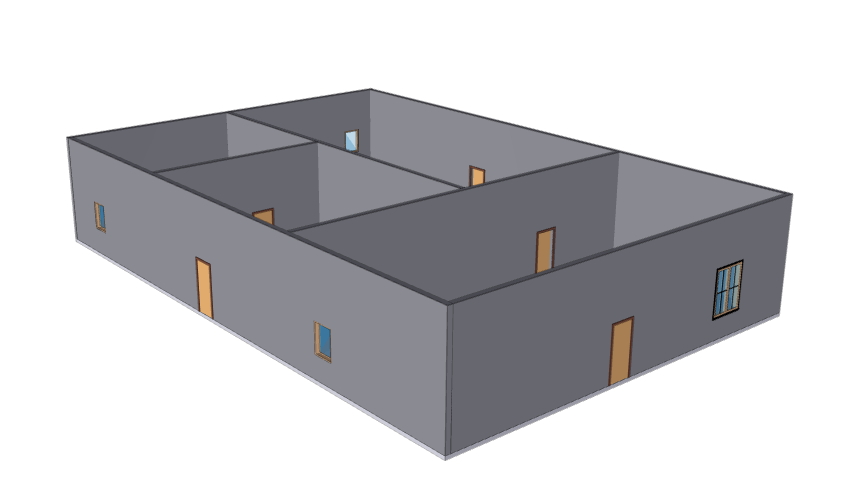

Let's add some walls and display the additions.

![added.jpg](../images/added.jpg)

Let's now delete the one this newly added wall, and also one of the windows.

![deleted.jpg](../images/deleted.jpg)

Now, let's make some changes regarding a wall position and a door position.

![modified.jpg](../images/modified.jpg)

Finally, if we can see the real difference between the original file and the last version (after adding, deleting, and modifying)

![all_changes.jpg](../images/all_changes.jpg)

### Further work

For future work, we'll see how to produce more detailed visualisations and go back to the history of the changes known by the biggest file of this tutorial. 